<h1><b>IMAGE RECOGNITION</b></h1>

Through this notebook, we will build a deep learning Tensorflow model for our Food Recognition using transfer learning from ResNet50

----------

## **PROBLEM DEFINITION**

1. **Problem Objective :** A Food Recognition Model aims to identify and classify food items from user-provided images. The primary objective is to accurately detect and categorize the food in the input image.

2. **Problem Goals :**

*   Develop the model using TensorFlow, leveraging transfer learning from ResNet50 for improved performance and efficiency.
*   Accurately predict the type of food present in user-submitted images.



## **PACKAGE IMPORTING**

In [14]:
!pip install --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.18.0
3.5.0


In [15]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random


## **DATASET GATHERING**

### Retrieve Dataset

In [17]:
import gdown

file_id = 'https://drive.google.com/file/d/14cdP6GHisrCKxx-uJVuCAsFcwg1VGCdZ/view?usp=sharing'

output_path = 'image_detection.v2i.tfrecord.zip'

gdown.download(url=file_id, output=output_path, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=14cdP6GHisrCKxx-uJVuCAsFcwg1VGCdZ
From (redirected): https://drive.google.com/uc?id=14cdP6GHisrCKxx-uJVuCAsFcwg1VGCdZ&confirm=t&uuid=499de76b-2537-4bcc-8c5f-72556b85b31a
To: /content/image_detection.v2i.tfrecord.zip
100%|██████████| 186M/186M [00:02<00:00, 77.5MB/s]


'image_detection.v2i.tfrecord.zip'

In [18]:
!unzip /content/image_detection.v2i.tfrecord.zip

Archive:  /content/image_detection.v2i.tfrecord.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: README.roboflow.txt     
replace test/food.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test/food.tfrecord      
replace test/food_label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test/food_label_map.pbtxt  
replace train/food.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train/food.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train/food.tfrecord     
replace train/food_label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/food_label_map.pbtxt  
replace valid/food.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: valid/food.tfrecord     
  inflating: valid/food_label_map.pbtxt  


### Image Preprocessing

In [19]:
train_dataset = tf.data.TFRecordDataset("/content/train/food.tfrecord")
test_dataset = tf.data.TFRecordDataset("/content/test/food.tfrecord")
valid_dataset = tf.data.TFRecordDataset("/content/valid/food.tfrecord")

for raw_record in train_dataset.take(4):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
        value: "Nasi"
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
        value: 28
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
        value: 0.296875
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list {
        value: 0.657812476
      }
    }
  }
  feature {
    key: "image/object/bbox/xmin"
    value {
      float_list {
        value: 0.342187494
      }
    }
  }
  feature {
    key: "image/object/bbox/xmax"
    value {
      float_list {
        value: 0.6375
      }
    }
  }
  feature {
    key: "image/height"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
  

In [20]:
# Load the label map and create a dictionary mapping class IDs to names
def load_label_map(label_map_path):
    temp = {}
    class_id = None
    with open(label_map_path, 'r') as f:
        for line in f:
            if 'id:' in line:
                class_id = int(line.split('id:')[1].strip().rstrip(','))
            if 'display_name:' in line and class_id is not None:
                class_name = line.split('display_name:')[1].strip().replace("'", "").replace('"', "").replace(",", "")
                temp[class_id] = class_name
    return temp

class_mapping = load_label_map("/content/train/food_label_map.pbtxt")
class_mapping

{1: 'Air',
 2: 'Anggur',
 3: 'Apel',
 4: 'Ayam',
 5: 'Bakso',
 6: 'Bakwan',
 7: 'Batagor',
 8: 'Bebek Betutu',
 9: 'Bubur',
 10: 'Burger',
 11: 'Cakwe',
 12: 'Capcay',
 13: 'Crepes',
 14: 'Cumi',
 15: 'Donat',
 16: 'Durian',
 17: 'Es Krim',
 18: 'Fuyunghai',
 19: 'Gado Gado',
 20: 'Gudeg',
 21: 'Ikan',
 22: 'Jeruk',
 23: 'Kacang',
 24: 'Kebab',
 25: 'Kentang',
 26: 'Kerupuk',
 27: 'Kopi',
 28: 'Nasi',
 29: 'Nasi Goreng',
 30: 'Pempek',
 31: 'Rawon',
 32: 'Rendang',
 33: 'Sate',
 34: 'Soto',
 35: 'Susu'}

In [21]:
def parse_tfrecord_fn(example, max_boxes=2, num_classes=35):
    # Define the feature description dictionary
    feature_description = {
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    }

    # Parse the input `tf.train.Example`
    parsed_features = tf.io.parse_single_example(example, feature_description)

    # Decode the image
    image = tf.io.decode_jpeg(parsed_features['image/encoded'])
    image = tf.image.resize(image, [224, 224])

    # Convert sparse tensors to dense tensors for bounding boxes
    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'], default_value=0.0)
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'], default_value=0.0)
    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'], default_value=0.0)
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'], default_value=0.0)

    # Combine all bounding boxes into one tensor of shape (num_boxes, 4)
    bboxes = tf.stack([ymin, xmin, ymax, xmax], axis=-1)

    # Truncate bounding boxes if necessary to keep only the first max_boxes
    bboxes = bboxes[:max_boxes]

    # # Pad bounding boxes if necessary
    # bboxes = tf.pad(bboxes, [[0, max_boxes - tf.shape(bboxes)[0]], [0, 0]], constant_values=0.0)

    # Get class labels (convert sparse tensor to dense)
    labels = tf.sparse.to_dense(parsed_features['image/object/class/label'], default_value=0)

    # Slice labels to keep only the first max_boxes
    labels = labels[:max_boxes]

    # Pad labels to match the max number of boxes
    # labels = tf.pad(labels, [[0, max_boxes - tf.shape(labels)[0]]], constant_values=0)

    # One-hot encode class labels
    one_hot_labels = tf.one_hot(labels, num_classes)

    # Pad bounding boxes and labels if necessary to ensure max_boxes shape
    bboxes = tf.pad(bboxes, [[0, max_boxes - tf.shape(bboxes)[0]], [0, 0]], constant_values=0.0)
    one_hot_labels = tf.pad(one_hot_labels, [[0, max_boxes - tf.shape(one_hot_labels)[0]], [0, 0]], constant_values=0.0)

    return image, (bboxes, one_hot_labels)


# Create a dataset from the TFRecord file
train_dataset = tf.data.TFRecordDataset("/content/train/food.tfrecord")
test_dataset = tf.data.TFRecordDataset("/content/test/food.tfrecord")
valid_dataset = tf.data.TFRecordDataset("/content/valid/food.tfrecord")

# Map the parse function to the dataset
train_dataset = train_dataset.map(parse_tfrecord_fn)
test_dataset = test_dataset.map(parse_tfrecord_fn)
valid_dataset = valid_dataset.map(parse_tfrecord_fn)

# Optional: Perform batching and data augmentation (e.g., resizing)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

# Iterate through the dataset and access the image and associated features
# for image, features, labels_text in train_dataset:
#     print(features)  # Dictionary of parsed features
#     # Further processing (e.g., bounding box, labels, etc.)

In [22]:
for image, (bboxes, labels) in train_dataset.take(5):  # Inspect 5 samples
    print("Image shape:", image.shape)
    print("Bounding box shape:", bboxes.shape)
    print("Class labels shape:", labels.shape)

Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)
Image shape: (16, 224, 224, 3)
Bounding box shape: (16, 2, 4)
Class labels shape: (16, 2, 35)


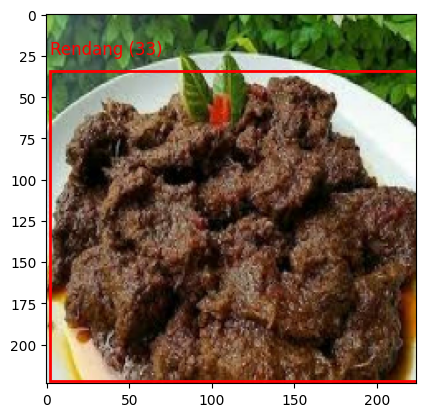

In [23]:
def display_random_image_with_bbox(dataset):
    """Displays a random image from the dataset with its bounding box."""
    image_data = list(dataset.as_numpy_iterator())  # Convert the dataset to a list for random access
    random_index = random.randint(0, len(image_data) - 1)
    image, (bboxes, labels) = image_data[random_index]

    # Assuming the first image in the batch is what we want (batch size = 1)
    image = image[0]
    bboxes = bboxes[0]
    labels = labels[0]

    # Find the first non-zero bounding box (object present)
    for i in range(bboxes.shape[0]):
      if np.any(bboxes[i] != 0):
        ymin, xmin, ymax, xmax = bboxes[i]
        # Convert normalized coordinates to pixel coordinates
        height, width, _ = image.shape
        x1 = int(xmin * width)
        y1 = int(ymin * height)
        x2 = int(xmax * width)
        y2 = int(ymax * height)

        class_id = np.argmax(labels[i]) # Get class ID from one-hot encoded labels
        class_name = class_mapping.get(class_id, "Unknown") # +1 because class_mapping starts from 1

        plt.imshow(image.astype(np.uint8))  # added .astype(np.uint8) for displaying
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1})", color='red', fontsize=12)
        plt.show()
        break
    else:
      print("No objects found in the selected image")

# Call the function
display_random_image_with_bbox(train_dataset)

## **MODELLING**

In [24]:
def create_object_detection_model(model='resnet', input_shape=(224, 224, 3), num_classes=35, max_boxes=2):

    # Input layer
    inputs = Input(shape=input_shape)

    # Pre-trained ResNet50 as feature extractor
    if model == 'mobilenet':
      base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=inputs)
      base_model.trainable = False
    elif model == 'inception':
      base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=inputs)
      base_model.trainable = False
    else:
      base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
      base_model.trainable = False  # Freeze ResNet50 layers

      # Unfreeze the last few layers of ResNet50
      for layer in base_model.layers[-10:]:
          layer.trainable = True

    # Global Average Pooling
    x = GlobalAveragePooling2D()(base_model.output)

    # First Dense Layer
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second Dense Layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    # Output for Bounding Boxes
    bbox_output = Dense(max_boxes * 4, activation='linear', name='bbox_output')(x)
    bbox_output_reshape = Reshape((max_boxes, 4), name='bbox_output_reshape')(bbox_output)

    # Output for Classification
    class_output = Dense(max_boxes * num_classes, activation='softmax', name='class_output')(x)
    class_output_reshape = Reshape((max_boxes, num_classes), name='class_output_reshape')(class_output)

    # Define the model with two outputs
    model = Model(inputs=inputs, outputs=[bbox_output_reshape, class_output_reshape])

    optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)

    # Compile the model with appropriate loss functions and optimizer
    model.compile(
        optimizer=optimizer,  # Consider using a lower learning rate if issues persist
        loss={
            'bbox_output_reshape': tf.keras.losses.MeanSquaredError(),  # or 'smooth_l1'
            'class_output_reshape': tf.keras.losses.CategoricalCrossentropy()
        },
        metrics={
            'bbox_output_reshape': tf.keras.losses.MeanAbsoluteError(),  # Mean Absolute Error
            'class_output_reshape': tf.keras.metrics.CategoricalAccuracy()
        }
    )

    return model


# Create the model
model = create_object_detection_model(model='resnet')

# Check the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,791,246 (94.57 MB)

 Trainable params: 5,667,662 (21.62 MB)

 Non-trainable params: 19,123,584 (72.95 MB)

In [25]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset
)

Epoch 1/20
    156/Unknown 36s 102ms/step - bbox_output_reshape_loss: 2.7323 - bbox_output_reshape_mean_absolute_error: 1.2603 - class_output_reshape_categorical_accuracy: 0.0834 - class_output_reshape_loss: 1.7085 - loss: 4.4408

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - bbox_output_reshape_loss: 2.7278 - bbox_output_reshape_mean_absolute_error: 1.2590 - class_output_reshape_categorical_accuracy: 0.0837 - class_output_reshape_loss: 1.7066 - loss: 4.4345 - val_bbox_output_reshape_loss: 5.0551 - val_bbox_output_reshape_mean_absolute_error: 1.4371 - val_class_output_reshape_categorical_accuracy: 0.1848 - val_class_output_reshape_loss: 3.2774 - val_loss: 8.3390
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - bbox_output_reshape_loss: 0.9760 - bbox_output_reshape_mean_absolute_error: 0.7235 - class_output_reshape_categorical_accuracy: 0.2175 - class_output_reshape_loss: 1.0051 - loss: 1.9812 - val_bbox_output_reshape_loss: 0.0863 - val_bbox_output_reshape_mean_absolute_error: 0.2243 - val_class_output_reshape_categorical_accuracy: 0.3412 - val_class_output_reshape_loss: 0.6636 - val_loss: 0.7489
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - bbox_output_reshape_loss: 0.4465 - bbox_output_reshape

In [26]:
# Evaluate the model on the test dataset
test_loss, test_class_loss, test_bbox_loss, test_class_acc, test_bbox_acc = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Classification Loss: {test_class_loss}")
print(f"Test BBox Loss: {test_bbox_loss}")
print(f"Test Classification Accuracy: {test_class_acc}")
print(f"Test BBox Accuracy: {test_bbox_acc}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - bbox_output_reshape_loss: 0.0348 - bbox_output_reshape_mean_absolute_error: 0.1250 - class_output_reshape_categorical_accuracy: 0.4346 - class_output_reshape_loss: 0.3259 - loss: 0.3611
Test Loss: 0.3740125000476837
Test Classification Loss: 0.030326545238494873
Test BBox Loss: 0.3395208716392517
Test Classification Accuracy: 0.11894501000642776
Test BBox Accuracy: 0.442176878452301


In [27]:
# Create the model
model = create_object_detection_model(model='mobilenet')

# Check the model summary
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset
)

# Evaluate the model on the test dataset
test_loss, test_class_loss, test_bbox_loss, test_class_acc, test_bbox_acc = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Classification Loss: {test_class_loss}")
print(f"Test BBox Loss: {test_bbox_loss}")
print(f"Test Classification Accuracy: {test_class_acc}")
print(f"Test BBox Accuracy: {test_bbox_acc}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,068,302 (11.70 MB)

 Trainable params: 808,782 (3.09 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - bbox_output_reshape_loss: 2.7002 - bbox_output_reshape_mean_absolute_error: 1.2718 - class_output_reshape_categorical_accuracy: 0.0668 - class_output_reshape_loss: 1.8407 - loss: 4.5410 - val_bbox_output_reshape_loss: 0.4606 - val_bbox_output_reshape_mean_absolute_error: 0.5456 - val_class_output_reshape_categorical_accuracy: 0.1588 - val_class_output_reshape_loss: 1.6123 - val_loss: 2.0738
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - bbox_output_reshape_loss: 0.9079 - bbox_output_reshape_mean_absolute_error: 0.7147 - class_output_reshape_categorical_accuracy: 0.1740 - class_output_reshape_loss: 1.2987 - loss: 2.2067 - val_bbox_output_reshape_loss: 0.1107 - val_bbox_output_reshape_mean_absolute_error: 0.2611 - val_class_output_reshape_categorical_accuracy: 0.2099 - val_class_output_reshape_loss: 1.2281 - val_loss: 1.3365
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - bbox_output_reshape_loss: 0.3801 - bbox_outp

In [28]:
# Create the model
model = create_object_detection_model(model='inception')

# Check the model summary
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset
)

# Evaluate the model on the test dataset
test_loss, test_class_loss, test_bbox_loss, test_class_acc, test_bbox_acc = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Classification Loss: {test_class_loss}")
print(f"Test BBox Loss: {test_bbox_loss}")
print(f"Test Classification Accuracy: {test_class_acc}")
print(f"Test BBox Accuracy: {test_bbox_acc}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,006,318 (87.76 MB)

 Trainable params: 1,201,998 (4.59 MB)

 Non-trainable params: 21,804,320 (83.18 MB)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 261ms/step - bbox_output_reshape_loss: 2.6125 - bbox_output_reshape_mean_absolute_error: 1.2583 - class_output_reshape_categorical_accuracy: 0.0567 - class_output_reshape_loss: 1.9244 - loss: 4.5369 - val_bbox_output_reshape_loss: 0.4350 - val_bbox_output_reshape_mean_absolute_error: 0.5331 - val_class_output_reshape_categorical_accuracy: 0.1118 - val_class_output_reshape_loss: 1.7590 - val_loss: 2.1908
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - bbox_output_reshape_loss: 0.8358 - bbox_output_reshape_mean_absolute_error: 0.7015 - class_output_reshape_categorical_accuracy: 0.1053 - class_output_reshape_loss: 1.4213 - loss: 2.2572 - val_bbox_output_reshape_loss: 0.0961 - val_bbox_output_reshape_mean_absolute_error: 0.2468 - val_class_output_reshape_categorical_accuracy: 0.1515 - val_class_output_reshape_loss: 1.4319 - val_loss: 1.5259
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - bbox_output_reshape_loss: 0.3065 - bbox_outp

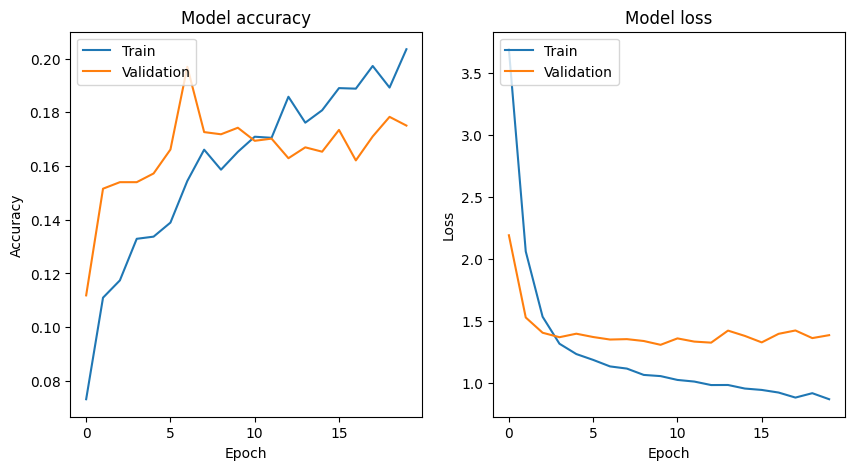

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_reshape_categorical_accuracy'])
plt.plot(history.history['val_class_output_reshape_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


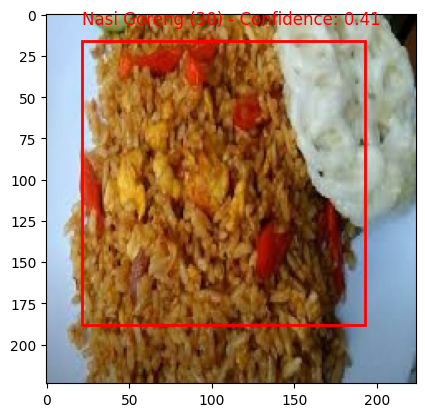

In [30]:
def predict_and_display_image(dataset, model, confidence_threshold=0):
    """Predicts and displays a random image from the dataset with bounding boxes,
       ensuring confidence is above the threshold.
    """
    image_data = list(dataset.as_numpy_iterator())
    while True:  # Keep trying until a suitable image is found
        random_index = random.randint(0, len(image_data) - 1)
        image, (bboxes, labels) = image_data[random_index]
        image = image[0]  # Get the first image in the batch
        bboxes = bboxes[0]
        labels = labels[0]

        predicted_bboxes, predicted_labels = model.predict(np.expand_dims(image, axis=0))
        predicted_bboxes = predicted_bboxes[0]
        predicted_labels = predicted_labels[0]

        # Find an object with confidence above the threshold
        for i in range(predicted_bboxes.shape[0]):
          if np.any(predicted_bboxes[i]!=0):
            class_id = np.argmax(predicted_labels[i])
            confidence = np.max(predicted_labels[i]) # Assuming softmax output for confidence

            if confidence >= confidence_threshold:
                ymin, xmin, ymax, xmax = predicted_bboxes[i]
                height, width, _ = image.shape
                x1 = int(xmin * width)
                y1 = int(ymin * height)
                x2 = int(xmax * width)
                y2 = int(ymax * height)

                class_name = class_mapping.get(class_id, "Unknown")

                plt.imshow(image.astype(np.uint8))
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1}) - Confidence: {confidence:.2f}", color='red', fontsize=12)
                plt.show()
                return # Exit the function after displaying a valid prediction

        print("No object found with sufficient confidence. Trying a different image...")
# Call the function
predict_and_display_image(test_dataset, model)

In [31]:
model.save('food_bbox.keras')

## **TESTING**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No object found with sufficient confidence. Trying a different image...
1/1 ━━━━━━━━

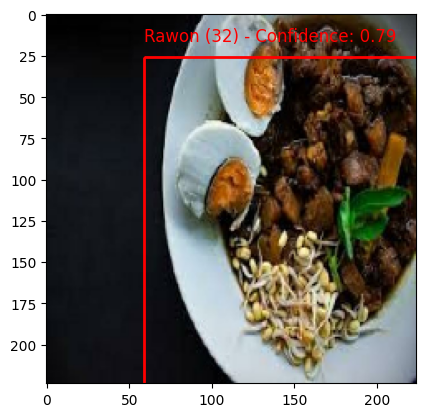

In [32]:
# Load the model
loaded_model = keras.models.load_model('food_bbox.keras')

# Now you can use the loaded_model for predictions
def predict_and_display_image(dataset, model, confidence_threshold=0.75):
    """Predicts and displays a random image from the dataset with bounding boxes,
       ensuring confidence is above the threshold.
    """
    image_data = list(dataset.as_numpy_iterator())
    while True:  # Keep trying until a suitable image is found
        random_index = random.randint(0, len(image_data) - 1)
        image, (bboxes, labels) = image_data[random_index]
        image = image[0]  # Get the first image in the batch
        bboxes = bboxes[0]
        labels = labels[0]

        predicted_bboxes, predicted_labels = model.predict(np.expand_dims(image, axis=0))
        predicted_bboxes = predicted_bboxes[0]
        predicted_labels = predicted_labels[0]

        # Find an object with confidence above the threshold
        for i in range(predicted_bboxes.shape[0]):
          if np.any(predicted_bboxes[i]!=0):
            class_id = np.argmax(predicted_labels[i])
            confidence = np.max(predicted_labels[i]) # Assuming softmax output for confidence

            if confidence >= confidence_threshold:
                ymin, xmin, ymax, xmax = predicted_bboxes[i]
                height, width, _ = image.shape
                x1 = int(xmin * width)
                y1 = int(ymin * height)
                x2 = int(xmax * width)
                y2 = int(ymax * height)

                class_name = class_mapping.get(class_id, "Unknown")

                plt.imshow(image.astype(np.uint8))
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(x1, y1 - 10, f"{class_name} ({class_id + 1}) - Confidence: {confidence:.2f}", color='red', fontsize=12)
                plt.show()
                return # Exit the function after displaying a valid prediction

        print("No object found with sufficient confidence. Trying a different image...")
# Call the function with the loaded model
predict_and_display_image(test_dataset, loaded_model)